In [2]:
import os
import numpy as np
import art
import torchvision
from torchvision import transforms as transforms
from PIL import Image
import torch
import torchvision.models as models
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pycocotools.coco import COCO
import random
import cv2
import pycocotools.coco as coco
import mean_average_precision

np.random.seed(43)

In [3]:
annFile='annotations\instances_val2017.json'
coco=COCO(annFile)
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]

nms = set([cat['supercategory'] for cat in cats])

catIds = coco.getCatIds(catNms=['giraffe','zebra','elephant']);
imgIds=[]
for i in catIds:
    imgIds.append(coco.getImgIds(catIds=i ))
imgIds = [item for sublist in imgIds for item in sublist]
np.random.shuffle(imgIds)
randImgIds = imgIds[:10]
#coco.download(tarDir = "photos", imgIds = randImgIds)

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


In [4]:
art_model = art.estimators.object_detection.PyTorchFasterRCNN(clip_values=[0,255])

In [5]:
def draw_image_with_boxes(image_as_array, model):
    predictions = model.predict(np.float32(image_as_array))
    print(predictions)
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(predictions[0]['labels'])]
    boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions[0]['boxes'])] # Bounding boxes
    pred_score = list(predictions[0]['scores'])
    img = np.resize(image_as_array, image_as_array.shape[1:])
    for i in range(len(boxes)):
        if pred_score[i] > 0.4:
            cv2.rectangle(img, boxes[i][0], boxes[i][1],color= (255,0,0), thickness=2) # Draw rectangle
            cv2.putText(img,pred_class[i] + ", "+ str(round(pred_score[i],2)), boxes[i][0],  cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0),thickness=2) # Write the prediction class and score     
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def load_image_from_path(img_path):
    image = Image.open(img_path).convert('RGB')
    image_as_array = np.array(image)
    image_as_array = np.expand_dims(image_as_array, 0)
    return image_as_array
    
def make_images_array(dictionary, width,height):
    images_paths = [f for f in os.listdir(dictionary) if os.path.isfile(os.path.join(dictionary, f))]
    #(n,width,height,3)
    images_array = np.empty([len(images_paths),width,height,3])
    
    for i, image_path in enumerate(images_paths):
        image = Image.open(dictionary +"/" + image_path).convert('RGB')
        image = image.resize((width,height))
        img_arr = np.array(image)
        images_array[i,:,:,:] = np.array(image)
    return images_array



Loading models, both of them are pretrained on COCO dataset <br />
Here is link to model documentation: https://pytorch.org/vision/stable/models.html#faster-r-cnn

Let's read a real image and get them to our model

In [6]:
image = Image.open("giraffe.jpg").convert('RGB')

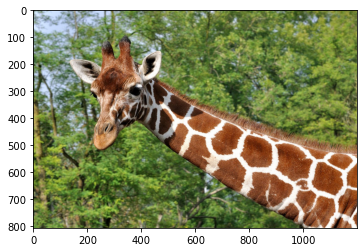

In [7]:
imgplot = plt.imshow(image)
plt.show()

In [8]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

We can put an np.array image directly to our model and get appropriate output

Now we can add predicted boxes to our picture <br/>
Pictures seems to be slightly too big

(1, 683, 1024, 3)
[{'boxes': array([[563.2966 , 345.4033 , 880.6374 , 596.13367],
       [187.74016, 220.00261, 500.19757, 578.8625 ],
       [464.5193 , 448.03387, 589.05597, 567.2614 ]], dtype=float32), 'labels': array([22, 22, 22], dtype=int64), 'scores': array([0.999671  , 0.99941766, 0.9988954 ], dtype=float32)}]


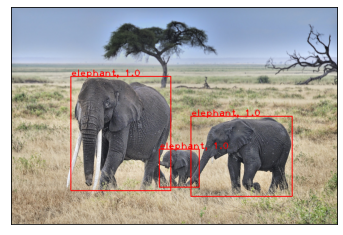

In [9]:
array = load_image_from_path("elephant.jpg")
print(array.shape)
draw_image_with_boxes(array, art_model)

In [10]:
attackDPatch = art.attacks.evasion.DPatch(art_model, batch_size = 1, max_iter = 500)
attackRobustDPatch = art.attacks.evasion.RobustDPatch(art_model, batch_size = 1, max_iter = 500)

In [11]:
images_array = make_images_array("photos", 224, 224)
print(images_array.shape)

(11, 224, 224, 3)


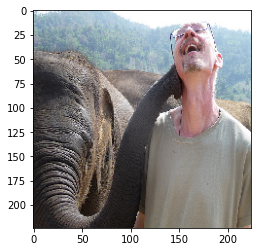

In [12]:
image = Image.fromarray(np.uint8(images_array[0,:,:,:]))
plt.imshow(image)
plt.show()

In [14]:
print(attackDPatch)
print(attackRobustDPatch)

Now we can conduct attact

In [15]:
adv_patch_robust = attackRobustDPatch.generate(np.float32(images_array[0:1,:,:,:]))

RobustDPatch iteration:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
mask = (np.zeros(images_array.shape[1:-1]) == 0)
mask = np.expand_dims(mask, 0)
torch.cuda.empty_cache()

In [18]:
adv_patch_dpatch = attackDPatch.generate(np.float32(images_array[0:1,:,:,:]), mask = mask)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 6.00 GiB total capacity; 4.18 GiB already allocated; 5.81 MiB free; 4.21 GiB reserved in total by PyTorch)

In [19]:
print(adv_patch_robust.shape)

(40, 40, 3)


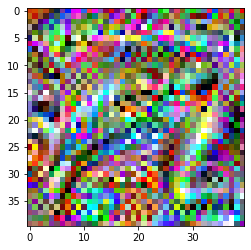

In [20]:
patch_img = Image.fromarray((adv_patch_robust).astype(np.uint8))
patch_img.save("RobustDPatch5000.png")
patch_img.save("RobustDPatch500.jpg", quality=100)
plt.imshow(patch_img)
plt.show()

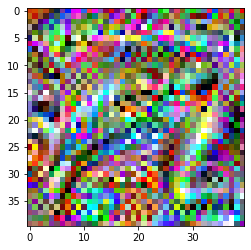

In [13]:
adv_patch_robust = load_image_from_path("RobustDPatch5000.png")
adv_patch_robust.resize((40,40,3))
image = Image.open("RobustDPatch5000.png").convert('RGB')
plt.imshow(image)
plt.show()

In [14]:
pathed_image = attackRobustDPatch.apply_patch(np.float32(images_array), patch_external=adv_patch_robust)

[{'boxes': array([[  4.7716265,   5.129993 ,  37.259216 ,  34.707985 ],
       [  3.7795727,   1.5974112,  36.45576  ,  21.886747 ],
       [119.250404 , 101.05175  , 176.53825  , 157.22073  ],
       [ 37.288177 , 104.14278  ,  74.39384  , 161.73454  ],
       [  2.1932316,   8.1468315,  40.093655 ,  87.57862  ],
       [  0.3918231,   0.       ,  51.384266 , 113.16666  ]],
      dtype=float32), 'labels': array([77, 77, 24, 24, 77,  6], dtype=int64), 'scores': array([0.99999833, 0.9997471 , 0.9987601 , 0.9980652 , 0.30340135,
       0.05478857], dtype=float32)}]


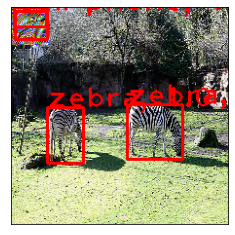

In [15]:
torch.cuda.empty_cache()
image = pathed_image[1,:,:,:].astype(int)
image = np.expand_dims(image, 0)
draw_image_with_boxes(image, art_model)

[{'boxes': array([[119.250404, 101.05175 , 176.53825 , 157.22073 ],
       [ 37.288177, 104.14278 ,  74.39384 , 161.73454 ]], dtype=float32), 'labels': array([24, 24], dtype=int64), 'scores': array([0.9987601, 0.9980652], dtype=float32)}]


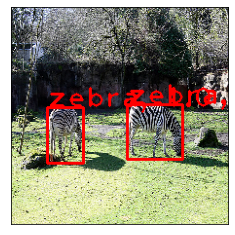

In [16]:
normal_images = images_array[1,:,:,:].astype(int)
normal_images = np.expand_dims(normal_images, 0)
#print(image)
draw_image_with_boxes(normal_images, art_model)

[{'boxes': array([[  4.0664024,   4.011485 ,  38.580006 ,  36.005882 ],
       [  1.9386281,   0.       ,  37.740814 ,  22.355036 ],
       [ 36.36224  ,  12.241404 , 224.       , 217.59048  ],
       [  2.1003056,   6.209108 ,  47.27642  , 107.9385   ],
       [138.93915  ,  12.887263 , 223.95561  , 213.48322  ],
       [  0.       ,   0.       ,  47.132267 , 144.65907  ]],
      dtype=float32), 'labels': array([77, 77, 22, 77, 22, 15], dtype=int64), 'scores': array([0.99999714, 0.99995744, 0.88964313, 0.6827057 , 0.5217208 ,
       0.05432183], dtype=float32)}]


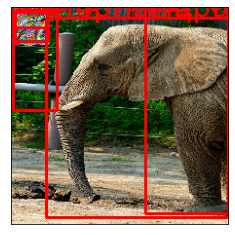

In [17]:
torch.cuda.empty_cache()
image = pathed_image[3,:,:,:].astype(int)
image = np.expand_dims(image, 0)
draw_image_with_boxes(image, art_model)

[{'boxes': array([[ 30.824448,  11.674064, 224.      , 211.5922  ],
       [138.93915 ,  12.887263, 223.95561 , 213.48322 ]], dtype=float32), 'labels': array([22, 22], dtype=int64), 'scores': array([0.9369347, 0.5217208], dtype=float32)}]


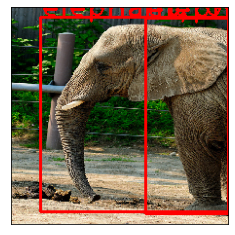

In [18]:
normal_images = images_array[3,:,:,:].astype(int)
normal_images = np.expand_dims(normal_images, 0)
#print(image)
draw_image_with_boxes(normal_images, art_model)

In [31]:
torch.cuda.empty_cache()
attact_predictions = art_model.predict(np.float32(pathed_image[0,:,:,:]))
torch.cuda.empty_cache()
normal_predictions = art_model.predict(np.float32(normal_images))
print(attact_predictions)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 6.00 GiB total capacity; 3.87 GiB already allocated; 0 bytes free; 4.21 GiB reserved in total by PyTorch)

In [3]:
def patched_to_MAP(preds):
    filter_normal = preds["scores"] > 0.1
    filter_scores = preds["scores"][filter_normal]
    stack = np.stack((preds["labels"], preds["scores"]), axis=1)
    gt = np.concatenate((preds["boxes"], stack), axis=1)
    gt = gt[filter_normal]
    return gt
    
def normal_to_MAP(preds):
    normal = patched_to_MAP(preds)
    normal = normal[:,0:5]
    N = normal.shape[0]
    normal = np.concatenate((normal, np.zeros((N,2))), axis = 1)
    return normal

In [4]:
boxes = np.array([[1,2,3,4],[5,6,7,8]])
labels = np.array([0,1])
scores = np.array([0.4,0.7])
normal_preds = {"boxes": boxes, "labels": labels, "scores": scores}

In [5]:
print(normal_preds)

{'boxes': array([[1, 2, 3, 4],
       [5, 6, 7, 8]]), 'labels': array([0, 1]), 'scores': array([0.4, 0.7])}


In [8]:
normalmAP = normal_to_MAP(normal_preds)
patchedmAP = patched_to_MAP(normal_preds)
patchedmAP[0,1] = 10 
print(normalmAP)
print(patchedmAP)

[[1. 2. 3. 4. 0. 0. 0.]
 [5. 6. 7. 8. 1. 0. 0.]]
[[ 1.  10.   3.   4.   0.   0.4]
 [ 5.   6.   7.   8.   1.   0.7]]


In [9]:
from mean_average_precision import MeanAveragePrecision

# create metric_fn
metric_fn = MeanAveragePrecision(num_classes=2)

# add some samples to evaluation
for i in range(1000):
    metric_fn.add(patchedmAP, normalmAP)

# compute PASCAL VOC metric
print(f"VOC PASCAL mAP: {metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']}")

# compute PASCAL VOC metric at the all points
print(f"VOC PASCAL mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")

# compute metric COCO metric
print(f"COCO mAP: {metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']}")

VOC PASCAL mAP: 0.5
VOC PASCAL mAP in all points: 0.5
COCO mAP: 0.5


In [19]:
defence_gausian = art.defences.preprocessor.GaussianAugmentation()
defence = art.defences.preprocessor.SpatialSmoothing()

In [35]:
art_model_defence = art.estimators.object_detection.PyTorchFasterRCNN(clip_values=[0,255],preprocessing_defences= [defence_gausian] )

[{'boxes': array([[119.25038 , 101.051765, 176.53824 , 157.22072 ],
       [ 37.288166, 104.14277 ,  74.39384 , 161.73453 ]], dtype=float32), 'labels': array([24, 24], dtype=int64), 'scores': array([0.9987601, 0.9980652], dtype=float32)}, {'boxes': array([[119.22848 , 101.043106, 176.60011 , 157.23659 ],
       [ 37.389614, 104.14085 ,  74.38262 , 161.72769 ]], dtype=float32), 'labels': array([24, 24], dtype=int64), 'scores': array([0.998684 , 0.9980521], dtype=float32)}]


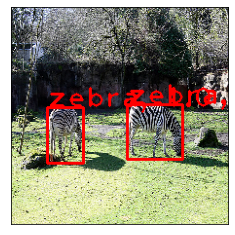

In [34]:
normal_images = images_array[1,:,:,:].astype(int)
normal_images = np.expand_dims(normal_images, 0)
#print(image)
draw_image_with_boxes(normal_images,art_model_with_defence )

[{'boxes': array([[  4.771624  ,   5.129994  ,  37.259216  ,  34.70798   ],
       [  3.7795792 ,   1.5973973 ,  36.455746  ,  21.886715  ],
       [119.25038   , 101.051765  , 176.53824   , 157.22072   ],
       [ 37.288166  , 104.14277   ,  74.39384   , 161.73453   ],
       [  2.1932337 ,   8.1468315 ,  40.09366   ,  87.57865   ],
       [  0.39182526,   0.        ,  51.384266  , 113.16664   ]],
      dtype=float32), 'labels': array([77, 77, 24, 24, 77,  6], dtype=int64), 'scores': array([0.99999833, 0.9997471 , 0.9987601 , 0.9980652 , 0.30340058,
       0.05478841], dtype=float32)}, {'boxes': array([[  4.784115 ,   5.1558733,  37.244457 ,  34.70461  ],
       [  3.8291388,   1.5571785,  36.408474 ,  22.01136  ],
       [119.30383  , 101.13117  , 176.51231  , 157.23538  ],
       [ 37.293728 , 104.14992  ,  74.384415 , 161.81447  ],
       [  2.2734106,   8.122132 ,  40.133305 ,  88.44621  ],
       [  0.4385425,   0.       ,  51.925438 , 112.80533  ]],
      dtype=float32), 'labels

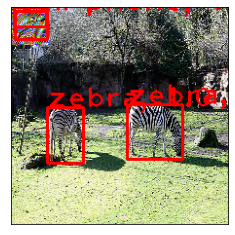

In [38]:
torch.cuda.empty_cache()
image = pathed_image[1,:,:,:].astype(int)
image = np.expand_dims(image, 0)
draw_image_with_boxes(image,art_model_defence )